# Livestock Mortality Index

This notebook will attempt to replicate and expand on a model to forecast the risk of livestock mortality in aimags (provinces) of Mongolia. The index is based on work completed by the People in Need NGO and the English report is available in this repository.

## Data import

The data used in the model is stored in a PDF file as tables. These tables were copied into an Excel spreadsheet and several cleaning and transformation steps took place. The original data copied from the PDF report is in **data/DATASET for MVDI report.xlsx** and the cleaned data is stored at **data/MVDI Tables Cleaned.xlsx**.

In [1]:
#Import required libraries
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [2]:
xls = pd.ExcelFile('data/MVDI Tables Cleaned.xlsx')

In [3]:
sheets = xls.sheet_names
sheets

['temp',
 'loss',
 'index',
 'pasture_anomaly',
 'pasture',
 'biomass_anomaly',
 'biomass',
 'zootechnical',
 'mortality',
 'fecundity',
 'snowfall_anomaly']

In [4]:
temp = xls.parse('temp')
loss = xls.parse('loss')
index = xls.parse('index')
pasture_anomaly = xls.parse('pasture_anomaly')
pasture = xls.parse('pasture')
biomass_anomaly = xls.parse('biomass_anomaly')
biomass = xls.parse('biomass')
zootechnical = xls.parse('zootechnical')
mortality = xls.parse('mortality')
fecundity = xls.parse('fecundity')
snowfall_anomaly = xls.parse('snowfall_anomaly')

In [5]:
dfs = [temp,loss, index, pasture_anomaly, pasture, biomass_anomaly, biomass, zootechnical, mortality,fecundity,snowfall_anomaly]

In [6]:
from functools import reduce
df = reduce(lambda  left,right: pd.merge(left,right,on=['Aimag','Year'], how='inner'), dfs)

In [7]:
df['Aimag'].unique()

array(['Arkhangai', 'Bayankhongor', 'Bayan‐Ulgii', 'Bulgan', 'Dornod',
       'Dornogovi', 'Dundgovi', 'Govisumber', 'Khentii', 'Khovd',
       'Khuvsgul', 'Orkhon', 'Selenge', 'Sukhbaatar', 'Tuv',
       'Ulaanbaatar', 'Umnugovi', 'Uvs', 'Uvurkhangai', 'Zavkhan'],
      dtype=object)

In [8]:
df.head()

,Aimag,Year,Temprature anomalies,Livestock Loss Rates from - 1998-2017,Past values of the vulnerability index according to Aimag - 1: Average weighed by livestock numbers in SFU,Pasture Use Anomaly,Pasture Use,Standing forage biomass anomaly,Standing forage biomass (tons),Zootechnical score,Mortality score,Fecundity score,Snowfall anomalies
0,Arkhangai,1999,2.75,0.01,1.69,0.04,0.11,0.05,2.96E+ 07,0,0,0,-3.80
1,Arkhangai,2000,-0.39,0.06,1.94,0.18,0.12,-0.13,2.44E+ 07,0,0,0,4.57
2,Arkhangai,2001,-1.62,0.24,2.63,-0.02,0.10,-0.22,2.20E+ 07,2,1,1,8.10
3,Arkhangai,2002,0.86,0.04,2.81,0.63,0.17,-0.57,1.22E+ 07,0,0,0,5.44
4,Arkhangai,2003,-0.10,0.07,1.15,-0.25,0.08,-0.07,2.61E+ 07,0,0,0,9.70


## Data Cleaning

Now that we have all of our features in one dataframe we can start cleaning the dataset so it is in a better format. 

To do:
- Rename features to be more simple and allow for easier reference
- Standing forage biomass was stored in the original report as scientific notation. This is now stored as text. 
- 

### Rename Columns

In [9]:
df.columns

Index(['Aimag', 'Year', 'Temprature anomalies',
       'Livestock Loss Rates from - 1998-2017',
       'Past values of the vulnerability index according to Aimag - 1: Average weighed by livestock numbers in SFU',
       'Pasture Use Anomaly', 'Pasture Use', 'Standing forage biomass anomaly',
       'Standing forage biomass (tons)', 'Zootechnical score',
       'Mortality score', 'Fecundity score', 'Snowfall anomalies'],
      dtype='object')

In [10]:
df.rename(index=str,columns={'Aimag':'aimag', 'Year':'year', 'Temprature anomalies':'temperature_anomaly',
       'Livestock Loss Rates from - 1998-2017':'livestock_loss',
       'Past values of the vulnerability index according to Aimag - 1: Average weighed by livestock numbers in SFU':'index',
       'Pasture Use Anomaly':'pasture_use_anomaly', 'Pasture Use':'pasture_use', 'Standing forage biomass anomaly':'biomass_anomaly',
       'Standing forage biomass (tons)':'biomass', 'Zootechnical score':'zootechnical',
       'Mortality score':'mortality', 'Fecundity score':'fecundity', 'Snowfall anomalies':'snowfall_anomaly'},inplace=True)

### Convert biomass to numeric feature

The biomass feature is stored in the format '2.96E+ 07' (scientific notation). We do not have access to the complete number, so we will concatenate the number and take the left three characters. 

In [11]:
df['biomass'] = df['biomass'].str[:4]

In [12]:
df['biomass'] = pd.to_numeric(df['biomass'])

In [13]:
df.head()

,aimag,year,temperature_anomaly,livestock_loss,index,pasture_use_anomaly,pasture_use,biomass_anomaly,biomass,zootechnical,mortality,fecundity,snowfall_anomaly
0,Arkhangai,1999,2.75,0.01,1.69,0.04,0.11,0.05,2.96,0,0,0,-3.80
1,Arkhangai,2000,-0.39,0.06,1.94,0.18,0.12,-0.13,2.44,0,0,0,4.57
2,Arkhangai,2001,-1.62,0.24,2.63,-0.02,0.10,-0.22,2.20,2,1,1,8.10
3,Arkhangai,2002,0.86,0.04,2.81,0.63,0.17,-0.57,1.22,0,0,0,5.44
4,Arkhangai,2003,-0.10,0.07,1.15,-0.25,0.08,-0.07,2.61,0,0,0,9.70


## Confusion Matrix

As the MVDI research paper gives us mortality and the output risk scores, we can create an independent accuracy assessment. In addition, we can use the papers own classification methodology to create a confusion matrix that will allow us to assess false positives and negatives.

The classification methodology creates bins for the risk scores that correspond to a range of mortality. It is as follows:

Index value Mean mortality
- 0‐1     1%
- 1‐2     3%
- 2‐3     6%
- 3+      17%

As the bins for both the index and mean mortality don't say which boundary is inclusive or exclusive, we will need to do a little determination of our own. 

Index --- Mean Mortality
- 0-1  [0%-3%]
- 1-2  (3%-6%]
- 2-3  (6%-17%]
- 3+   (17%+)

The confusion matrix was created in Excel and is located in the 'data' directory.

## Recreating MVDI Index

Using the data in the MVDI report, I will attempt to recreate the index using the available data. Some key points:

- We do not have the dataframe or a flat file we can import to ensure we have the correct data format. Our data was copied from PDF tables and assembled into our dataframe here.
- The standing forage biomass data was written in scientific notation in the report, meaning we may have a loss of data with our truncated numbers.
- The original model was created in R using the geeglm package. This is a general linear model. We can somewhat replicate this via the Linear Regression. However the current scikit learn package does not support a poisson distribution in a GLM. Given this we can assume that a replicated model using scikit learn would have a lower performance.

Given our lack of ability to replicate the original model, we will attempt to instead use the same features and test multiple algorithms. In addition, we will later attempt to do some feature engineering to explore whether we can improve upon this base model futher. 


In [14]:
%%html
<img src="assets/features.PNG",width=500>

In [15]:
df.head()

,aimag,year,temperature_anomaly,livestock_loss,index,pasture_use_anomaly,pasture_use,biomass_anomaly,biomass,zootechnical,mortality,fecundity,snowfall_anomaly
0,Arkhangai,1999,2.75,0.01,1.69,0.04,0.11,0.05,2.96,0,0,0,-3.80
1,Arkhangai,2000,-0.39,0.06,1.94,0.18,0.12,-0.13,2.44,0,0,0,4.57
2,Arkhangai,2001,-1.62,0.24,2.63,-0.02,0.10,-0.22,2.20,2,1,1,8.10
3,Arkhangai,2002,0.86,0.04,2.81,0.63,0.17,-0.57,1.22,0,0,0,5.44
4,Arkhangai,2003,-0.10,0.07,1.15,-0.25,0.08,-0.07,2.61,0,0,0,9.70


Here we will shift the four N-1 features. We will also drop the original features and save our dataframe.

In [16]:
df = df.groupby('aimag')['biomass_anomaly','zootechnical','pasture_use_anomaly'].shift(1).merge(df,
                left_index=True,right_index=True,suffixes=('_1', '')).drop(columns=[
                'biomass_anomaly','zootechnical','pasture_use_anomaly'],axis=1)


In [17]:
df.head()

,biomass_anomaly_1,zootechnical_1,pasture_use_anomaly_1,aimag,year,temperature_anomaly,livestock_loss,index,pasture_use,biomass,mortality,fecundity,snowfall_anomaly
0,NaN,NaN,NaN,Arkhangai,1999,2.75,0.01,1.69,0.11,2.96,0,0,-3.80
1,0.05,0.0,0.04,Arkhangai,2000,-0.39,0.06,1.94,0.12,2.44,0,0,4.57
2,-0.13,0.0,0.18,Arkhangai,2001,-1.62,0.24,2.63,0.10,2.20,1,1,8.10
3,-0.22,2.0,-0.02,Arkhangai,2002,0.86,0.04,2.81,0.17,1.22,0,0,5.44
4,-0.57,0.0,0.63,Arkhangai,2003,-0.10,0.07,1.15,0.08,2.61,0,0,9.70


### Construct training dataframe.

Using the features from the report we can construct our dataframe. We have the 'index' values as created by the MVDI model. 

- The target variable is livestock_loss, which is expressed as a fraction of 1 (100%)

Here is the fit function as given by the report:
> gee.fit <- geeglm(Loss_rate_Y_100~Snowfall11_3_anomaly_Y*Forage_anomaly_Y_minus_1*Zootechnical_index_Y_minus_1+Temp11_2_anomaly_Y*Pasture_Use_Y_minus_1_anomaly*Zootechnical_index_Y_minus_1,
id=Aimag_code, waves= Year, data=Mortality_Mongolia_geepack, family=poisson, corstr=”exch”)

As such we can add the following features to our training dataframe:

- snowfall_anomaly (N)
- biomass_anomaly (N-1)
- zootechnical (N-1)
- temperature_anomaly (N)
- pasture_use_anomaly (N-1)
- livestock_loss (target variable)

In [18]:
df.columns

Index(['biomass_anomaly_1', 'zootechnical_1', 'pasture_use_anomaly_1', 'aimag',
       'year', 'temperature_anomaly', 'livestock_loss', 'index', 'pasture_use',
       'biomass', 'mortality', 'fecundity', 'snowfall_anomaly'],
      dtype='object')

In [19]:
train = df.drop(columns=[
    'aimag','year','fecundity','mortality',
    'biomass','pasture_use','index'], axis=1)

In [20]:
train.head()

,biomass_anomaly_1,zootechnical_1,pasture_use_anomaly_1,temperature_anomaly,livestock_loss,snowfall_anomaly
0,NaN,NaN,NaN,2.75,0.01,-3.80
1,0.05,0.0,0.04,-0.39,0.06,4.57
2,-0.13,0.0,0.18,-1.62,0.24,8.10
3,-0.22,2.0,-0.02,0.86,0.04,5.44
4,-0.57,0.0,0.63,-0.10,0.07,9.70


We will drop the NaN values as this row will not be able to be used in the training algorithm.

In [21]:
train = train.dropna(axis=0).reset_index(drop=True)

In [22]:
train.head()

,biomass_anomaly_1,zootechnical_1,pasture_use_anomaly_1,temperature_anomaly,livestock_loss,snowfall_anomaly
0,0.05,0.0,0.04,-0.39,0.06,4.57
1,-0.13,0.0,0.18,-1.62,0.24,8.10
2,-0.22,2.0,-0.02,0.86,0.04,5.44
3,-0.57,0.0,0.63,-0.10,0.07,9.70
4,-0.07,0.0,-0.25,0.54,0.01,2.30


In [23]:
train.shape

(300, 6)

## Train GLM Algorithms - Original Dataset

The model in the MVDI report is a GLM model (generalized linear model). A poisson distribution is specifically mentioned, so here we will attempt to use models that support this.

In [24]:
y = train['livestock_loss']
X = train.drop(columns=['livestock_loss'],axis=1)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### Linear Regression

In [26]:
from sklearn.linear_model import LinearRegression

params = {"model_type": "Linear Regression"
          }

reg = LinearRegression()
reg.fit(X_train, y_train)

regr_pred = reg.predict(X_test)
regression_score = reg.score(X_test, y_test)
lin_rmse = np.sqrt((mean_squared_error(y_test, regr_pred)))

print("R^2: ", regression_score)
print("RMSE: ", lin_rmse)

R^2:  0.43973529695413777
RMSE:  0.06985463757468893


#### Ridge Regression

In [27]:
from sklearn.linear_model import Ridge

params = {"model_type": "Ridge Regression"
          }

ridge = Ridge(alpha=.5)
ridge.fit(X_train, y_train) 

ridge_pred = ridge.predict(X_test)
ridge_score = ridge.score(X_test, y_test)
ridge_rmse = np.sqrt((mean_squared_error(y_test, ridge_pred)))

print("R^2: ", ridge_score)
print("RMSE: ", ridge_rmse)

R^2:  0.43535875299914095
RMSE:  0.07012694383381707


#### XGBoost

In [28]:
from xgboost import XGBRegressor

params = {"model_type": "XGBRegressor",
          "random_state": 42,
          "n_estimators": 100
          }

xgb = XGBRegressor(random_state=params['random_state'], n_estimators=params['n_estimators'])
xgb.fit(X_train,y_train)

xgb_pred = xgb.predict(X_test)
xgb_score = xgb.score(X_test, y_test)
xgb_rmse = np.sqrt((mean_squared_error(y_test, xgb_pred)))

print("R^2: ", xgb_score)
print("RMSE: ", xgb_rmse)

R^2:  0.41344904539413185
RMSE:  0.07147455916648646


#### Random Forest Regressor

In [29]:
from sklearn.ensemble import RandomForestRegressor

params = {"model_type": "Random Forest",
          "random_state": 42,
          "n_estimators": 300
          }

rf = RandomForestRegressor(random_state=params['random_state'], n_estimators=params['n_estimators'])
rf.fit(X_train,y_train)

rf_pred = rf.predict(X_test)
rf_score = rf.score(X_test, y_test)
rf_rmse = np.sqrt((mean_squared_error(y_test, rf_pred)))

print("R^2: ", rf_score)
print("RMSE: ", rf_rmse)

R^2:  0.41124301181046596
RMSE:  0.07160884187422596


#### Extra Trees

In [30]:
from sklearn.ensemble import ExtraTreesRegressor

extra = ExtraTreesRegressor(random_state=42, 
                            n_estimators=100,
                           min_samples_split=5)
extra.fit(X_train,y_train)

extra_pred = extra.predict(X_test)
extra_score = extra.score(X_test, y_test)
extra_rmse = np.sqrt((mean_squared_error(y_test, extra_pred)))

print("R^2: ", extra_score)
print("RMSE: ", extra_rmse)

R^2:  0.4739248409938822
RMSE:  0.0676896876434779


#### AdaBoost

In [31]:
from sklearn.ensemble import AdaBoostRegressor

params = {"model_type": "AdaBoost",
          "random_state": 42,
          "n_estimators": 300
          }

ada = AdaBoostRegressor(random_state=params['random_state'], n_estimators=params['n_estimators'])
ada.fit(X_train,y_train)

ada_pred = ada.predict(X_test)
ada_score = ada.score(X_test, y_test)
ada_rmse = np.sqrt((mean_squared_error(y_test, ada_pred)))

print("R^2: ", ada_score)
print("RMSE: ", ada_rmse)

R^2:  0.2158599397185037
RMSE:  0.08264097518689711


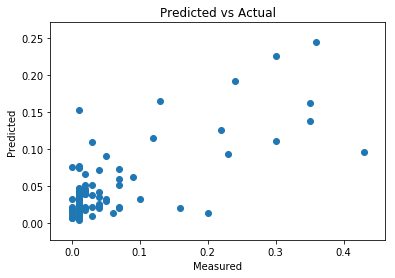

In [32]:
plt.scatter(y_test, extra_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

## Expanded training set

In [33]:
df.head()

,biomass_anomaly_1,zootechnical_1,pasture_use_anomaly_1,aimag,year,temperature_anomaly,livestock_loss,index,pasture_use,biomass,mortality,fecundity,snowfall_anomaly
0,NaN,NaN,NaN,Arkhangai,1999,2.75,0.01,1.69,0.11,2.96,0,0,-3.80
1,0.05,0.0,0.04,Arkhangai,2000,-0.39,0.06,1.94,0.12,2.44,0,0,4.57
2,-0.13,0.0,0.18,Arkhangai,2001,-1.62,0.24,2.63,0.10,2.20,1,1,8.10
3,-0.22,2.0,-0.02,Arkhangai,2002,0.86,0.04,2.81,0.17,1.22,0,0,5.44
4,-0.57,0.0,0.63,Arkhangai,2003,-0.10,0.07,1.15,0.08,2.61,0,0,9.70


In [34]:
df = df.groupby('aimag')['biomass_anomaly_1','zootechnical_1','pasture_use_anomaly_1'].shift(1).merge(df,
                left_index=True,right_index=True,suffixes=('_2', ''))

In [35]:
df = df.groupby('aimag')['biomass_anomaly_1','zootechnical_1','pasture_use_anomaly_1'].shift(2).merge(df,
                left_index=True,right_index=True,suffixes=('_3', ''))

In [36]:
df = df.groupby('aimag')['temperature_anomaly','livestock_loss', 'snowfall_anomaly'].shift(1).merge(df,
                left_index=True,right_index=True,suffixes=('_1', ''))

In [37]:
df = df.groupby('aimag')['temperature_anomaly','livestock_loss', 'snowfall_anomaly'].shift(2).merge(df,
                left_index=True,right_index=True,suffixes=('_2', ''))

In [38]:
train = df.drop(columns=[
    'aimag','year','fecundity','mortality',
    'biomass','pasture_use','index'], axis=1)

In [39]:
train.head()

,temperature_anomaly_2,livestock_loss_2,snowfall_anomaly_2,temperature_anomaly_1,livestock_loss_1,snowfall_anomaly_1,biomass_anomaly_1_3,zootechnical_1_3,pasture_use_anomaly_1_3,biomass_anomaly_1_2,zootechnical_1_2,pasture_use_anomaly_1_2,biomass_anomaly_1,zootechnical_1,pasture_use_anomaly_1,temperature_anomaly,livestock_loss,snowfall_anomaly
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.75,0.01,-3.80
1,NaN,NaN,NaN,2.75,0.01,-3.80,NaN,NaN,NaN,NaN,NaN,NaN,0.05,0.0,0.04,-0.39,0.06,4.57
2,2.75,0.01,-3.80,-0.39,0.06,4.57,NaN,NaN,NaN,0.05,0.0,0.04,-0.13,0.0,0.18,-1.62,0.24,8.10
3,-0.39,0.06,4.57,-1.62,0.24,8.10,0.05,0.0,0.04,-0.13,0.0,0.18,-0.22,2.0,-0.02,0.86,0.04,5.44
4,-1.62,0.24,8.10,0.86,0.04,5.44,-0.13,0.0,0.18,-0.22,2.0,-0.02,-0.57,0.0,0.63,-0.10,0.07,9.70


We will drop the NaN values as this row will not be able to be used in the training algorithm.

In [40]:
train = train.dropna(axis=0).reset_index(drop=True)

In [41]:
train.head()

,temperature_anomaly_2,livestock_loss_2,snowfall_anomaly_2,temperature_anomaly_1,livestock_loss_1,snowfall_anomaly_1,biomass_anomaly_1_3,zootechnical_1_3,pasture_use_anomaly_1_3,biomass_anomaly_1_2,zootechnical_1_2,pasture_use_anomaly_1_2,biomass_anomaly_1,zootechnical_1,pasture_use_anomaly_1,temperature_anomaly,livestock_loss,snowfall_anomaly
0,-0.39,0.06,4.57,-1.62,0.24,8.10,0.05,0.0,0.04,-0.13,0.0,0.18,-0.22,2.0,-0.02,0.86,0.04,5.44
1,-1.62,0.24,8.10,0.86,0.04,5.44,-0.13,0.0,0.18,-0.22,2.0,-0.02,-0.57,0.0,0.63,-0.10,0.07,9.70
2,0.86,0.04,5.44,-0.10,0.07,9.70,-0.22,2.0,-0.02,-0.57,0.0,0.63,-0.07,0.0,-0.25,0.54,0.01,2.30
3,-0.10,0.07,9.70,0.54,0.01,2.30,-0.57,0.0,0.63,-0.07,0.0,-0.25,-0.14,0.0,-0.17,-2.70,0.01,-2.33
4,0.54,0.01,2.30,-2.70,0.01,-2.33,-0.07,0.0,-0.25,-0.14,0.0,-0.17,-0.20,0.0,-0.03,-0.17,0.01,-3.23


In [42]:
train.shape

(260, 18)

In [43]:
y = train['livestock_loss']
X = train.drop(columns=['livestock_loss'],axis=1)

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=24)

#### Linear Regression

In [125]:
from sklearn.linear_model import LinearRegression

params = {"model_type": "Linear Regression"
          }

reg = LinearRegression()
reg.fit(X_train, y_train)

regr_pred = reg.predict(X_test)
regression_score = reg.score(X_test, y_test)
lin_rmse = np.sqrt((mean_squared_error(y_test, regr_pred)))

print("R^2: ", regression_score)
print("RMSE: ", lin_rmse)

R^2:  0.28764593278652495
RMSE:  0.057887544949609196


#### Ridge Regression

In [126]:
from sklearn.linear_model import Ridge

params = {"model_type": "Ridge Regression"
          }

ridge = Ridge(alpha=.5)
ridge.fit(X_train, y_train) 

ridge_pred = ridge.predict(X_test)
ridge_score = ridge.score(X_test, y_test)
ridge_rmse = np.sqrt((mean_squared_error(y_test, ridge_pred)))

print("R^2: ", ridge_score)
print("RMSE: ", ridge_rmse)

R^2:  0.31117134325223983
RMSE:  0.05692365532256701


#### XGBoost

In [127]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42, n_estimators=300, learning_rate=0.1)
xgb.fit(X_train,y_train)

xgb_pred = xgb.predict(X_test)
xgb_score = xgb.score(X_test, y_test)
xgb_rmse = np.sqrt((mean_squared_error(y_test, xgb_pred)))

print("R^2: ", xgb_score)
print("RMSE: ", xgb_rmse)

R^2:  0.44955335512915917
RMSE:  0.050885587327102556


#### Random Forest Regressor

In [128]:
from sklearn.ensemble import RandomForestRegressor

params = {"model_type": "Random Forest",
          "random_state": 42,
          "n_estimators": 700
          }

rf = RandomForestRegressor(random_state=params['random_state'], n_estimators=params['n_estimators'])
rf.fit(X_train,y_train)

rf_pred = rf.predict(X_test)
rf_score = rf.score(X_test, y_test)
rf_rmse = np.sqrt((mean_squared_error(y_test, rf_pred)))

print("R^2: ", rf_score)
print("RMSE: ", rf_rmse)

R^2:  0.38091910122390826
RMSE:  0.053964838204409046


#### Extra Trees

In [129]:
from sklearn.ensemble import ExtraTreesRegressor

extra = ExtraTreesRegressor(random_state=42, 
                            n_estimators=100)
extra.fit(X_train,y_train)

extra_pred = extra.predict(X_test)
extra_score = extra.score(X_test, y_test)
extra_rmse = np.sqrt((mean_squared_error(y_test, extra_pred)))

print("R^2: ", extra_score)
print("RMSE: ", extra_rmse)

R^2:  0.4702829319766869
RMSE:  0.049918228005203555


#### AdaBoost

In [130]:
from sklearn.ensemble import AdaBoostRegressor

params = {"model_type": "AdaBoost",
          "random_state": 42,
          "n_estimators": 300
          }

ada = AdaBoostRegressor(random_state=params['random_state'], n_estimators=params['n_estimators'])
ada.fit(X_train,y_train)

ada_pred = ada.predict(X_test)
ada_score = ada.score(X_test, y_test)
ada_rmse = np.sqrt((mean_squared_error(y_test, ada_pred)))

print("R^2: ", ada_score)
print("RMSE: ", ada_rmse)

R^2:  0.3294904887639737
RMSE:  0.056161622819095265


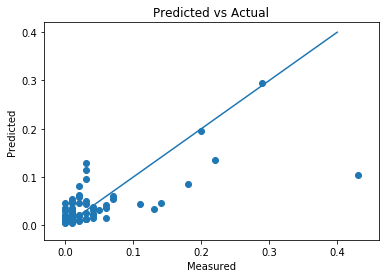

In [131]:
plt.scatter(y_test, extra_pred)
plt.plot(np.linspace(0, .4, 1000),np.linspace(0, .4, 1000))
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

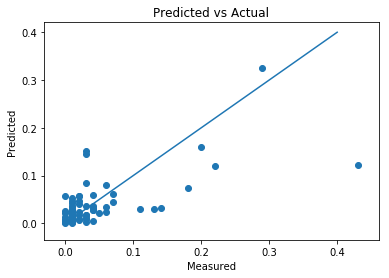

In [132]:
plt.scatter(y_test, xgb_pred)
plt.plot(np.linspace(0, .4, 1000),np.linspace(0, .4, 1000))
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

### Create confidence interval for best model

In [133]:
import forestci as fci
# Calculate the variance:
rf_pred_unbiased = fci.random_forest_error(rf, X_train, X_test)

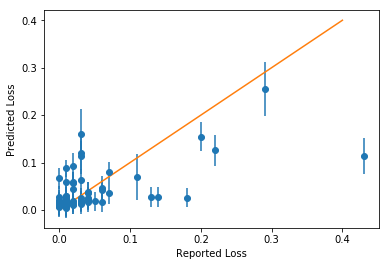

In [134]:
plt.errorbar(y_test, rf_pred, yerr=np.sqrt(rf_pred_unbiased), fmt='o')
plt.plot(np.linspace(0, .4, 1000),np.linspace(0, .4, 1000))
plt.xlabel('Reported Loss')
plt.ylabel('Predicted Loss')
plt.show()

In [135]:
def pred_ints(model, X, percentile=95):
    err_down = []
    err_up = []
    for x in range(len(X)):
        preds = []
        for pred in model.estimators_:
            preds.append(pred.predict(X.iloc[x:x+1,:])[0])
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))
    return err_down, err_up

err_down, err_up = pred_ints(extra, X, percentile=90)

In [136]:
y_pred = extra.predict(X)

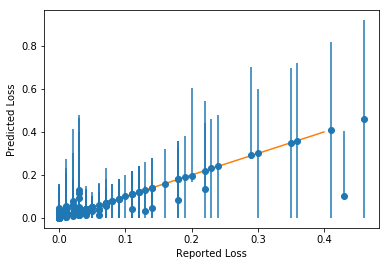

In [137]:
asymmetric_error = [err_down, err_up]

plt.errorbar(y, y_pred, yerr=asymmetric_error, fmt='o')
plt.plot(np.linspace(0, .4, 1000),np.linspace(0, .4, 1000))
plt.xlabel('Reported Loss')
plt.ylabel('Predicted Loss')
plt.show()